In [1]:
import torch
from torch import nn
from torch import optim
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import music_data_utils

In [3]:
musicDataLoader = music_data_utils.MusicDataLoader('./music_data', 0.2, 0.1)

Data loader: datadir: ./music_data
num genres:1
num composers: 154
limit works per composer: None
appending classical/adam/3003marquise.mid
appending classical/adam/3002robdia.mid
appending classical/adam/3000adamno_l.mid
appending classical/aguado/agupolo.mid
appending classical/aguado/AguadoMenuet1Op12.mid
appending classical/aguado/AguadoLessonNo1.mid
appending classical/aguado/aguadron.mid
appending classical/aguado/AguadoMenuet3Op12.mid
appending classical/albenizisaac/1149albcot.mid
appending classical/albenizisaac/1155asturian.mid
appending classical/albenizisaac/1151alb1gav.mid
appending classical/albenizisaac/1152albzgrda.mid
appending classical/albenizisaac/110.mid
appending classical/albenizisaac/39.mid
appending classical/albenizisaac/albesp5.mid
appending classical/albenizisaac/albesp4.mid
appending classical/albenizisaac/albesp6.mid
appending classical/albenizisaac/albesp3.mid
appending classical/albenizisaac/1148aicuba.mid
appending classical/albenizisaac/albesp2.mid
app

appending classical/grieg/2316tmgr54no5.mid
appending classical/grieg/1856pianoconcertop16no2.mid
appending classical/grieg/268Elfintnz.mid
appending classical/grieg/182.mid
appending classical/grieg/2314tmgr12no6.mid
appending classical/grieg/143.mid
appending classical/grieg/2320tmmntkng.mid
appending classical/grieg/2313tmgr12no3.mid
Path does not exist: ./music_data/classical/griff
appending classical/handel/butoh.mid
appending classical/handel/han4-4c.mid
appending classical/handel/222Handms35.mid
appending classical/handel/sheba.mid
appending classical/handel/Mes37.mid
appending classical/handel/mes23.mid
appending classical/handel/op6n09m3.mid
appending classical/handel/hans3a.mid
appending classical/handel/largo.mid
appending classical/handel/han-h2os.mid
appending classical/handel/op6n10m2.mid
appending classical/handel/han-flsn.mid
appending classical/handel/op6n10m3.mid
appending classical/handel/menuet.mid
appending classical/handel/op6n09m2.mid
appending classical/handel/m

appending classical/pachelbel/150.mid
appending classical/pachelbel/5643rdpart.mid
appending classical/pachelbel/1695tpinven4.mid
appending classical/paderewski/1841padmnuet.mid
Path does not exist: ./music_data/classical/pagg
appending classical/palestrina/1875palestrina.mid
appending classical/palestrina/2158gpagnsd2.mid
appending classical/palestrina/2153gpgloria.mid
appending classical/palestrina/2152gpkyrie.mid
appending classical/palestrina/1877voimiponeste.mid
appending classical/palestrina/2155gpbndcts.mid
appending classical/palestrina/2157gpagnsd1.mid
appending classical/palestrina/2154gpcredo.mid
appending classical/palestrina/1876almaredemptoris.mid
appending classical/palestrina/1878gpmaap0m.mid
appending classical/palestrina/2156gpsncts.mid
appending classical/paradisi/437toccata.mid
appending classical/paradisi/2161toccwb.mid
appending classical/poulenc/1820gloria.mid
appending classical/poulenc/1827poultdp4.mid
appending classical/poulenc/2020hymne.mid
appending classic

Reading files classical/adam: 3
Reading files classical/aguado: 5
Reading files classical/albenizisaac: 20
Reading files classical/albenizmateo: 2
Reading files classical/albinoni: 1
Reading files classical/alford: 2
Reading files classical/alkan: 11
Reading files classical/anderson: 8
Reading files classical/ansell: 1
Reading files classical/arensky: 5
Reading files classical/arriaga: 2
Reading files classical/bach: 100
Reading files classical/bach: 200
Reading files classical/bach: 300
Reading files classical/bach: 360
Reading files classical/barber: 8
Path does not exist: ./music_data/classical/barbieri
Reading files classical/bartok: 99
Reading files classical/bax: 2
Error reading ./music_data/classical/beethoven/14715thSympnmov1.mid
Reading files classical/beethoven: 68
Reading files classical/bellini: 4
Reading files classical/bergmuller: 48
Reading files classical/berlin: 3
Reading files classical/berlioz: 3
Reading files classical/binge: 3
Reading files classical/bizet: 17
Path

In [4]:
class Generator(nn.Module):
    def __init__(self, seq_length, in_channels, out_channels=4, hidden_dim=350, n_layers=3):
        super().__init__()
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.seq_length = seq_length
        ## in_channels represents the number of features 
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.lstm = nn.LSTM(
            input_size = self.in_channels, hidden_size = self.hidden_dim,
            num_layers = self.n_layers, batch_first = True
        )
        # We want the output to be a sequence of seq_length in which each value in the sequence
        # has 4 channels. Therefore, we'll need a tensor of size batch_size*seq_length*num_channels
        # For that, we need a linear layer that receives a tensor of size (batch_size, seq_length, hidden_dim)
        # and returns a tensor of size (batch_size, seq_length, out_channels)
        self.fc = nn.Linear(in_features = self.hidden_dim, out_features = self.out_channels)
        
    def forward(self, x, h=None):
        if (h==None):
            lstm_output, hidden = self.lstm(x)
        else:
            lstm_output, hidden = self.lstm(x, h)
        # Stack up LSTM outputs
        out = lstm_output.reshape(-1, self.hidden_dim) 
        out = self.fc(out)
        return out, hidden

In [5]:
class Discriminator(nn.Module):
    def __init__(self, seq_length, out_size=2, in_channels=4, hidden_dim=350, n_layers=2):
        super().__init__()
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.in_channels = in_channels
        self.out_size = out_size
        self.seq_length = seq_length
        self.lstm = nn.LSTM(
            input_size = in_channels, hidden_size = self.hidden_dim,
            num_layers = self.n_layers, batch_first = True
        )
        self.fc = nn.Linear(in_features = self.hidden_dim, out_features = 2)
        self.logsoftmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x, h=None):
        # input of shape (seq_len, batch, input_size)
        if (h==None):
            out, hidden = self.lstm(x)
        else:
            out, hidden = self.lstm(x, h)
        # output of shape (seq_len, batch, num_directions * hidden_size)
        out = out.reshape(-1, self.seq_length, self.hidden_dim)
        out = self.logsoftmax(self.fc(out))
        
        # return the final output and the hidden state
        return out, hidden

In [6]:
seq_length = 30
batch_length = 100
# Size of z latent vector (i.e. size of generator input)
nz = 20

netG = Generator(seq_length=seq_length, in_channels=nz)
print(netG)

netD = Discriminator(seq_length=seq_length)
print(netD)

Generator(
  (lstm): LSTM(20, 350, num_layers=3, batch_first=True)
  (fc): Linear(in_features=350, out_features=4, bias=True)
)
Discriminator(
  (lstm): LSTM(4, 350, num_layers=2, batch_first=True)
  (fc): Linear(in_features=350, out_features=2, bias=True)
  (logsoftmax): LogSoftmax()
)


In [7]:
# Initialize BCELoss function
criterion = nn.NLLLoss()

# Create batch of latent vectors that we will use to visualize
# the progression of the generator
fixed_noise = torch.randn(batch_length, nz, seq_length, 1, 1)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Learning rate for optimizers
lr = 0.1

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [9]:
generated_songs = []
G_losses = []
D_losses = []
iters = 0
num_epochs = 15

print('Start training...')
for epoch in range(num_epochs):
    start_time_epoch = time.time()
    musicDataLoader.rewind('train')
    batch_meta, batch_data = musicDataLoader.get_batch(batchsize=batch_length, songlength=seq_length)
    while batch_data is not None:
        ### Discriminator Networks
        ## Train on real Data
        netD.zero_grad()
        label_real = torch.full((batch_length,2), real_label).long()
        label_real[:,0] = fake_label
        
        output = netD.forward(torch.FloatTensor(batch_data))
        label_predicted = output[0]
        loss_real = criterion(label_predicted, label_real)
        loss_real.backward()
        D_x = torch.max(output[0], dim=1)[0].mean().item()
        
        ## Train on fake Data
        noise = torch.randn(batch_length, nz, seq_length, 1, 1)
        fake = netG.forward(noise.reshape(-1, 1, nz))
        label_fake = torch.index_select(label_real, 1, torch.LongTensor([1,0]))
        output = netD.forward(fake[0].reshape(batch_length, seq_length, 4))
        label_predicted = output[0]
        loss_fake = criterion(label_predicted, label_fake)
        loss_fake.backward(retain_graph=True)
        D_G_z1 = torch.max(output[0], dim=1)[0].mean().item()
        ## Add gradients from all real and all fake batches
        loss_discriminator = loss_real + loss_fake
        optimizerD.step()
        
        ### Generator Network
        netG.zero_grad()
        # fake labels are real for generator cost
        label_fake = torch.index_select(label_fake, 1, torch.LongTensor([1,0]))
        output = netD.forward(fake[0].reshape(batch_length, seq_length, 4))
        label_predicted = output[0]
        loss_fake_G = criterion(label_predicted, label_fake)
        loss_fake_G.backward()
        D_G_z2 = torch.max(output[0], dim=1)[0].mean().item()
        optimizerG.step()
        
        if iters % 10 == 0:
            print('[%d/%d][%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f\n Time since epoch started: %.2f'
                  % (epoch, num_epochs, iters,
                     loss_discriminator.item(), loss_fake_G.item(), 
                     D_x, D_G_z1, D_G_z2, 
                     time.time()-start_time_epoch))
            
        G_losses.append(loss_fake_G.item())
        D_losses.append(loss_discriminator.item())
            
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1)):
            with torch.no_grad():
                fake = netG.forward(fixed_noise.reshape(-1, 1, nz))
                generated_songs.append(fake.reshape(batch_length, seq_length, 4))

        iters += 1
        # Generate new batch
        batch_meta, batch_data = musicDataLoader.get_batch(batchsize=batch_length, songlength=seq_length)
    print('Epoch time: ', time.time()-start_time_epoch)

Start training...
[0/15][0]	Loss_D: 6.5579	Loss_G: 7.8321	D(x): -0.2796	D(G(z)): -0.0028 / -1.0262
 Time since epoch started: 4.30
[0/15][10]	Loss_D: 2.7448	Loss_G: 3.2981	D(x): -0.1188	D(G(z)): -0.0211 / -0.1142
 Time since epoch started: 69.63
[0/15][20]	Loss_D: 2.1301	Loss_G: 2.2585	D(x): -0.9467	D(G(z)): -0.6040 / -0.2912
 Time since epoch started: 176.50
Epoch time:  282.6977541446686
[1/15][30]	Loss_D: 1.5157	Loss_G: 1.0505	D(x): -0.4500	D(G(z)): -0.4542 / -0.5008
 Time since epoch started: 11.69
[1/15][40]	Loss_D: 2.2281	Loss_G: 0.7175	D(x): -0.1890	D(G(z)): -0.1444 / -0.6004
 Time since epoch started: 128.33
[1/15][50]	Loss_D: 2.0902	Loss_G: 1.1309	D(x): -0.3258	D(G(z)): -0.2799 / -0.9376
 Time since epoch started: 244.66
Epoch time:  346.0613052845001
[2/15][60]	Loss_D: 2.8577	Loss_G: 1.3664	D(x): -0.3798	D(G(z)): -0.3681 / -0.8525
 Time since epoch started: 11.64
[2/15][70]	Loss_D: 5.0919	Loss_G: 2.0385	D(x): -2.2038	D(G(z)): -2.1815 / -0.2961
 Time since epoch started: 127.8

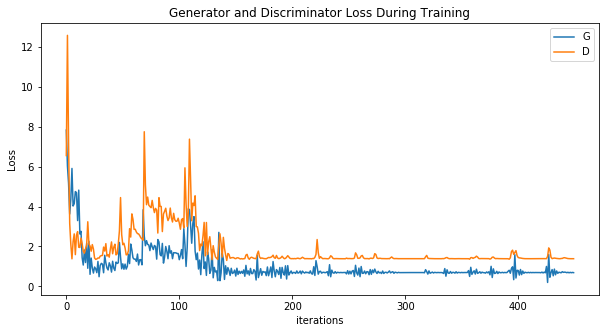

In [10]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

Probar nuevas maneras de entrenar!!
- Curriculum learning (ir cambiando la longitud de la secuencia)
- Parar el entrenamiento del discriminador si empieza a ser demasiado bueno respecto del generador durante un número de épocas.

In [44]:
a = []
for i in range(len(G_losses)//10):
    a.append(np.var(G_losses[i*10:(i+1)*10]))

In [65]:
b = []
for i in range(len(D_losses)//10):
    b.append(np.var(D_losses[i*10:(i+1)*10]))

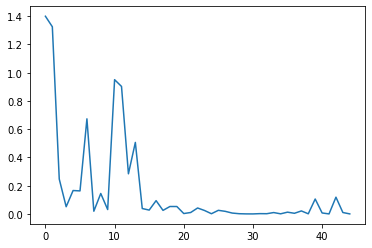

In [45]:
plt.plot(a)

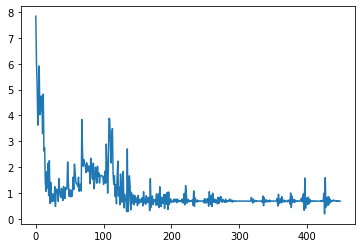

In [68]:
plt.plot(G_losses)

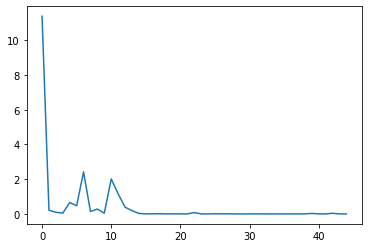

In [66]:
plt.plot(b)

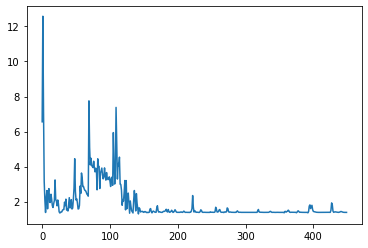

In [69]:
plt.plot(D_losses)

In [71]:
a = np.asarray(a)
print(np.where(a < 0.01)[0])
print(a[np.where(a < 0.01)[0]])

[20 21 24 27 28 29 30 31 32 33 34 36 38 40 41 43 44]
[2.65386644e-03 9.99507234e-03 1.36046471e-03 6.08293666e-03
 1.49467607e-03 2.12462536e-04 2.17973264e-07 1.99190055e-03
 1.49307234e-03 9.62481702e-03 7.08181909e-04 4.42068436e-03
 8.85770762e-04 6.75663815e-03 2.14730119e-05 9.90033669e-03
 1.27635261e-04]


In [70]:
b = np.asarray(b)
print(np.where(b < 0.01)[0])
print(b[np.where(b < 0.01)[0]])

[15 16 18 19 20 21 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 40 41
 43 44]
[2.95910429e-03 7.25791137e-03 3.23573131e-03 2.45422604e-03
 4.54938355e-04 1.18829326e-04 2.49588707e-03 8.15954421e-05
 9.12849284e-03 3.16451892e-03 7.40088034e-03 7.55507527e-04
 5.84186856e-06 4.38586497e-09 2.92246728e-03 6.98822969e-05
 4.25087223e-04 3.62045118e-06 5.58521522e-04 1.69993206e-03
 1.07788178e-03 9.07948143e-06 3.92918559e-04 4.59936587e-09
 1.05527888e-04 3.58093911e-04]


Here we are looking at where the variance seems to get low for both losses in such a way that we could determine when to increase the sequence length and therefore implement curriculum learning.

In [77]:
b[20] < 0.01 and a[20] < 0.01

True

In [81]:
print('The variances were {:.4f} for G and {:.4f} for D'.format(a[20], b[20]))

The variances were 0.0027 for G and 0.0005 for D


In [84]:
sum(a < 0.01)/len(a) 

0.37777777777777777

In [104]:
for i in range(1,len(a)):
    print('a and b', sum(b[-i:] < 0.01)/i >= 0.7 and sum(a[-i:] < 0.01)/i >= 0.7, i)

a and b True 1
a and b True 2
a and b False 3
a and b True 4
a and b True 5
a and b False 6
a and b True 7
a and b False 8
a and b False 9
a and b False 10
a and b False 11
a and b False 12
a and b False 13
a and b True 14
a and b True 15
a and b True 16
a and b True 17
a and b True 18
a and b True 19
a and b True 20
a and b True 21
a and b False 22
a and b False 23
a and b False 24
a and b False 25
a and b False 26
a and b False 27
a and b False 28
a and b False 29
a and b False 30
a and b False 31
a and b False 32
a and b False 33
a and b False 34
a and b False 35
a and b False 36
a and b False 37
a and b False 38
a and b False 39
a and b False 40
a and b False 41
a and b False 42
a and b False 43
a and b False 44


In [ ]:
for i in range(1,len(a)):
    print('a and b', sum(b[-i:] < 0.01)/i >= 0.7 and sum(a[-i:] < 0.01)/i >= 0.7, i)